In [1]:
import SIRD_Model

import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

In [2]:
pathc="../Data/Italian Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "National Data.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

In [3]:
from scipy.optimize import minimize


#note paramArg is in the format of [q, beta, gamma, nu]
def errorSIRD(paramArg, pop, I, R, D): #the custom error function for SIRD
    lamda = 10
    w = .9
    q = paramArg[0]
    b = paramArg[1:5]
    params = paramArg[4:] #beta3, gamma, nu
    params[0] = paramArg[1] #beta0, gamma, nu
    
    #note: beta = b0 / (1 + (I*b1 + D*b2)^b3)
    #use b0 in the place of b0, and multiply first column by 1/(1+(I*b1+D*b2)^b3)
    
    S = q*pop - I - R - D #q*Pop = S + I + R + D
    
    y, A = SIRD_Model.getSIRDMatrices(S, I, R, D)
    
    #transform location where beta is needed and multiply by 1/(1+(I*b1+D*b2)^b3)
    #A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    #A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    print(b, params)
    A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
    
    totalError = 0
    #see paper for optimization function
    T = len(A)
    for t in range(T):
        totalError = totalError + (w**(T - t))*(np.linalg.norm((A[t] @ params) - y[t].transpose(), ord=2)**2)
    
    #return (1.0/T) * np.linalg.norm((A @ params) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(params, ord=1)
    totalError = (1.0/T)*totalError #divide by timeframe
    totalError = totalError + lamda*np.linalg.norm(params, ord=1) #regularization error
    print(totalError)
    return totalError
    

pop = 60000000
numDays = 30 #len(infectRaw) #max days
infect = infectRaw[0:numDays]
recov = recovRaw[0:numDays]
dead = deadRaw[0:numDays]

defaultParams=[.1, 1,0,0,1 , .1, .1] #default guesses, q, beta0,beta1,beta2,beta3, gamma, nu

result = minimize(errorSIRD, defaultParams, args=(pop, infect, recov, dead),
                  method='BFGS', options={'maxiter': 5000})

q=result.x[0]
params=result.x[1:]
print(q, params)

[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.  0.1 0.1]
358403338.0272858
[1.00000001 0.         0.         1.00000001] [1.00000001 0.1        0.1       ]
358403350.4430361
[1.00000000e+00 1.49011612e-08 0.00000000e+00 1.00000000e+00] [1.  0.1 0.1]
357852636.9973632
[1.00000000e+00 0.00000000e+00 1.49011612e-08 1.00000000e+00] [1.  0.1 0.1]
358340608.80554694
[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.         0.10000001 0.1       ]
358403331.8053434
[1. 0. 0. 1.] [1.         0.1        0.10000001]
358403331.8275984
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.527698934
[0.9999757  1.00351086 0.11430636 0.9999757 ] [0.9999757  0.10000964 0.1000096 ]
36138057.52869678
[0.99997568 1.00351088 0.11430636 0.99997

<ipython-input-3-c18f29d33d33>:24: RuntimeWarning: invalid value encountered in power
  A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:25: RuntimeWarning: invalid value encountered in power
  A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])


nan
[-210297.49346974   -1381.86193258   12087.08134397 -210297.49346974] [-210297.49346974  207564.38833002 -206483.98220456]
nan
[-210297.49346976   -1381.86193256   12087.08134397 -210297.49346976] [-210297.49346976  207564.38833002 -206483.98220456]
nan
[-210297.49346976   -1381.86193258   12087.08134399 -210297.49346976] [-210297.49346976  207564.38833002 -206483.98220456]
nan
[-210297.49346976   -1381.86193258   12087.08134397 -210297.49346976] [-210297.49346976  207564.38833002 -206483.98220456]
nan
[-210297.49346976   -1381.86193258   12087.08134397 -210297.49346976] [-210297.49346976  207564.38833004 -206483.98220456]
nan
[-210297.49346976   -1381.86193258   12087.08134397 -210297.49346976] [-210297.49346976  207564.38833002 -206483.98220454]
nan
[-841231.48104057   -5527.81225667   48350.5259338  -841231.48104057] [-841231.48104057  830295.6431294  -825973.65558772]
nan
[-841231.48104057   -5527.81225667   48350.5259338  -841231.48104057] [-841231.48104057  830295.6431294  -8

<ipython-input-3-c18f29d33d33>:24: RuntimeWarning: invalid value encountered in power
  A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:25: RuntimeWarning: invalid value encountered in power
  A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:24: RuntimeWarning: invalid value encountered in power
  A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:25: RuntimeWarning: invalid value encountered in power
  A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])


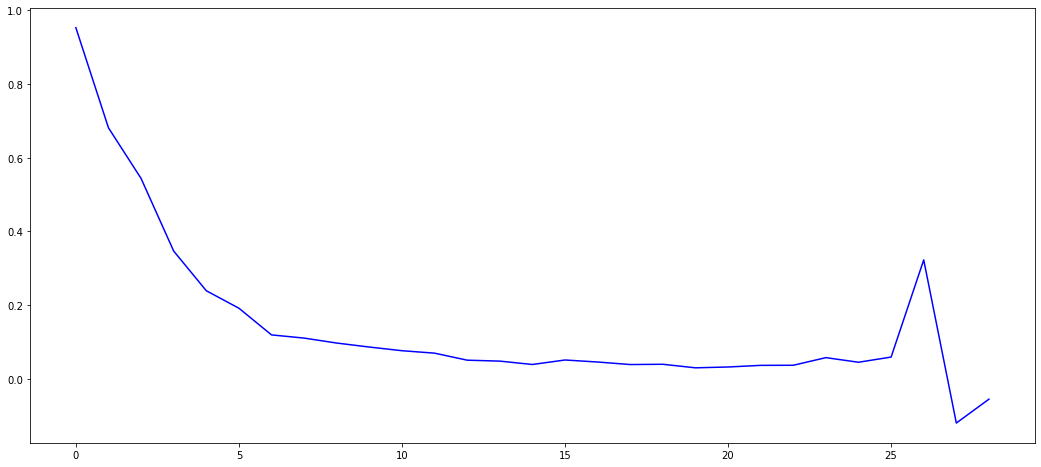

In [4]:
bT = params[0] / (1 + (infect[0:-1]*params[1] + dead[0:-1]*params[2])**params[3])
#print(bT)

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(bT, color='blue', label='beta')

In [5]:
defaultParams=[.1, 1,0,0,1 , .1, .1] #default guesses, q, beta0,beta1,beta2,beta3, gamma, nu

result = minimize(errorSIRD, defaultParams, args=(pop, infect, recov, dead),
                  method='BFGS', options={'maxiter': 5000})

[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.  0.1 0.1]
358403338.0272858
[1.00000001 0.         0.         1.00000001] [1.00000001 0.1        0.1       ]
358403350.4430361
[1.00000000e+00 1.49011612e-08 0.00000000e+00 1.00000000e+00] [1.  0.1 0.1]
357852636.9973632
[1.00000000e+00 0.00000000e+00 1.49011612e-08 1.00000000e+00] [1.  0.1 0.1]
358340608.80554694
[1. 0. 0. 1.] [1.  0.1 0.1]
358403337.09823555
[1. 0. 0. 1.] [1.         0.10000001 0.1       ]
358403331.8053434
[1. 0. 0. 1.] [1.         0.1        0.10000001]
358403331.8275984
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.52770513
[0.99997568 1.00351086 0.11430636 0.99997568] [0.99997568 0.10000964 0.1000096 ]
36138057.527698934
[0.9999757  1.00351086 0.11430636 0.9999757 ] [0.9999757  0.10000964 0.1000096 ]
36138057.52869678
[0.99997568 1.00351088 0.11430636 0.99997

<ipython-input-3-c18f29d33d33>:24: RuntimeWarning: invalid value encountered in power
  A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:25: RuntimeWarning: invalid value encountered in power
  A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])


[-52563.99657705   -345.37435154   3021.22019652 -52563.99657705] [-52563.99657705  51881.57463018 -51611.56385877]
nan
[-52563.99657705   -345.37435155   3021.22019653 -52563.99657705] [-52563.99657705  51881.57463018 -51611.56385877]
nan
[-52563.99657705   -345.37435155   3021.22019652 -52563.99657705] [-52563.99657705  51881.57463018 -51611.56385877]
nan
[-52563.99657705   -345.37435155   3021.22019652 -52563.99657705] [-52563.99657705  51881.57463019 -51611.56385877]
nan
[-52563.99657705   -345.37435155   3021.22019652 -52563.99657705] [-52563.99657705  51881.57463018 -51611.56385875]
nan
[-210297.49346976   -1381.86193258   12087.08134397 -210297.49346976] [-210297.49346976  207564.38833002 -206483.98220456]
nan
[-210297.49346976   -1381.86193258   12087.08134397 -210297.49346976] [-210297.49346976  207564.38833002 -206483.98220456]
nan
[-210297.49346976   -1381.86193258   12087.08134397 -210297.49346976] [-210297.49346976  207564.38833002 -206483.98220456]
nan
[-210297.49346974  

<ipython-input-3-c18f29d33d33>:24: RuntimeWarning: invalid value encountered in power
  A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:25: RuntimeWarning: invalid value encountered in power
  A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:24: RuntimeWarning: invalid value encountered in power
  A[:,0,0] = A[:,0,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
<ipython-input-3-c18f29d33d33>:25: RuntimeWarning: invalid value encountered in power
  A[:,1,0] = A[:,1,0] / (1 + (I[0:-1]*b[1] + D[0:-1]*b[2])**b[3])
